## Main notebook for the preprocessing-sorting-postprocessing pipeline with SpikeInterface

### Imports

In [34]:
import os
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import json
import spikeinterface.full as si
from probeinterface import read_probeinterface
from probeinterface.plotting import plot_probe
from adc_shifts import adc_shifts

%matplotlib widget

### Set pipeline parameters

In [3]:
pipeline_info_dict = {}

In [4]:
si.installed_sorters()

['spykingcircus', 'spykingcircus2', 'tridesclous', 'tridesclous2']

In [5]:
# Data loading
num_channels = 384
sampling_frequency = 2500
# see this thread https://community.brain-map.org/t/using-the-raw-data/1898 for gain scaling factor and dtype
gain_recording =4.69
offset_recording = 0
dtype = np.int16

pipeline_info_dict.update({'num_channels': num_channels, 'sampling_frequency': sampling_frequency, 'gain_recording': gain_recording, 'offset_recording': offset_recording, 'dtype': dtype})

In [6]:
# Preprocessing and sorting
highpass_frequency = 1 # Hz

sorter_name = 'kilosort3'
sorter_path = Path.home() / 'RANCZLAB-NAS' / 'spikesorter_images' / f'{sorter_name}-compiled-base.sif'
output_folder = Path.home() / 'RANCZLAB-NAS/output_sorter/mouse_343'
remove_existing_folder = True

pipeline_info_dict.update({'sorter_name': sorter_name, 'sorter_path': sorter_path, 'output_folder': output_folder, 'remove_existing_folder': remove_existing_folder})

In [7]:
# Other
backend = 'ipywidgets'

pipeline_info_dict.update({'backend': backend})

### Loading the data

#### Reading the binary file

In [8]:
# Main working directory
base_folder = Path.home() / 'RANCZLAB-NAS/data/ONIX/mouse_343/mouse_343_2024-06-20T131349Z' 

# Input data
binary_filename = 'LFP.bin'

# # Output sorting
# output_folder = base_folder / 'kilosort3_sorting_files'
# sorting_save_path = base_folder / 'kilosort3_sorting_output'

pipeline_info_dict.update({'data_path': base_folder, 'binary_filename': binary_filename})

In [9]:
os.listdir(base_folder)

['LFP.bin',
 'Clock.bin',
 'CurrentPosition.csv',
 'FrameCounter.bin',
 'SpikeData-001.bin']

In [10]:
recordings = {}
recordings['raw'] = si.read_binary(base_folder / binary_filename, sampling_frequency=sampling_frequency, dtype=dtype, num_channels=num_channels, gain_to_uV=1.0, offset_to_uV=0)
recordings['raw'] = si.scale(recordings['raw'], gain=gain_recording, offset=offset_recording) #scale to uV
recordings['raw']

ScaleRecording: 384 channels - 2.5kHz - 1 segments - 546,306 samples - 218.52s (3.64 minutes) 
                float32 dtype - 800.25 MiB

#### Attaching the probe configuration

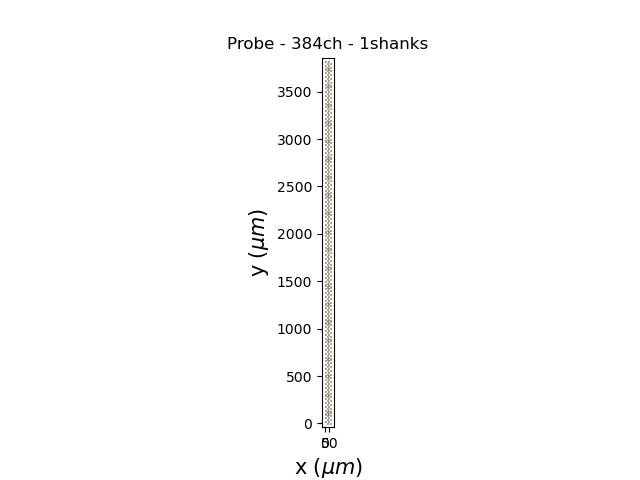

In [11]:
probegroup = read_probeinterface('np_json_files/np1.json')
probe = probegroup.probes[0]
recordings['raw'] = recordings['raw'].set_probe(probe)

plot_probe(probe)
plt.show()

### Preprocessing

In [12]:
# high pass signal
recordings['highpass'] = si.highpass_filter(recordings['raw'], freq_min=highpass_frequency)

In [ ]:
recordings['bandpass'] = si.bandpass_filter(recordings['highpass'], freq_min=1, freq_max=6000)

In [13]:
# perform the phase shift (similar to IBL destriping or `tshift` option in CatGT):
recordings['phase_shift'] = si.phase_shift(recordings['highpass'], inter_sample_shift=adc_shifts()[0])

In [14]:
# detect noisy, dead, and out-of-brain channels
bad_channel_ids, channel_labels = si.detect_bad_channels(recordings['highpass'])
recordings['good_channels'] = recordings['phase_shift'].remove_channels(remove_channel_ids=bad_channel_ids)

pipeline_info_dict.update({'channel_labels': channel_labels, 'bad_channel_ids': bad_channel_ids})

/opt/tljh/user/envs/jh_si_env/lib/python3.10/site-packages/spikeinterface/preprocessing/detect_bad_channels.py:324: RuntimeWarning: invalid value encountered in true_divide
  xcorr = np.sum(raw * ref[:, np.newaxis], axis=0) / np.sum(ref**2)
/opt/tljh/user/envs/jh_si_env/lib/python3.10/site-packages/spikeinterface/preprocessing/detect_bad_channels.py:213: UserWarning: Over 1/3 of channels are detected as bad. In the presence of a highnumber of dead / noisy channels, bad channel detection may fail (good channels may be erroneously labeled as dead).
  warnings.warn(


In [15]:
print('Channels removed:', {k: channel_labels[k] for k in bad_channel_ids})
print(len(bad_channel_ids))
num_channels= 384-len(bad_channel_ids)
print(num_channels)

Channels removed: {0: 'noise', 1: 'noise', 2: 'noise', 3: 'noise', 4: 'noise', 5: 'noise', 6: 'noise', 7: 'noise', 8: 'noise', 9: 'noise', 10: 'noise', 11: 'noise', 12: 'noise', 13: 'noise', 14: 'noise', 15: 'noise', 16: 'noise', 17: 'noise', 18: 'noise', 19: 'noise', 20: 'noise', 21: 'noise', 22: 'noise', 23: 'noise', 24: 'noise', 25: 'noise', 26: 'noise', 27: 'noise', 28: 'noise', 29: 'noise', 30: 'noise', 31: 'noise', 32: 'noise', 33: 'noise', 34: 'noise', 35: 'noise', 36: 'noise', 37: 'noise', 38: 'noise', 39: 'noise', 40: 'noise', 41: 'noise', 42: 'noise', 43: 'noise', 44: 'noise', 45: 'noise', 46: 'noise', 47: 'noise', 48: 'noise', 49: 'noise', 50: 'noise', 51: 'noise', 52: 'noise', 53: 'noise', 54: 'noise', 55: 'noise', 56: 'noise', 57: 'noise', 58: 'noise', 59: 'noise', 60: 'noise', 61: 'noise', 62: 'noise', 63: 'noise', 64: 'noise', 65: 'noise', 66: 'noise', 67: 'noise', 68: 'noise', 69: 'noise', 70: 'noise', 71: 'noise', 72: 'noise', 73: 'noise', 74: 'noise', 75: 'noise', 76:

In [16]:
# subtract the median across all channels
recordings['common_reference'] = si.common_reference(recordings['phase_shift'], operator="median", reference="global")

In [17]:
parameter_dict = si.get_default_sorter_params(sorter_name)

In [18]:
print(parameter_dict)

{'detect_threshold': 6, 'projection_threshold': [9, 9], 'preclust_threshold': 8, 'car': True, 'minFR': 0.2, 'minfr_goodchannels': 0.2, 'nblocks': 5, 'sig': 20, 'freq_min': 300, 'sigmaMask': 30, 'nPCs': 3, 'ntbuff': 64, 'nfilt_factor': 4, 'do_correction': True, 'NT': None, 'AUCsplit': 0.8, 'wave_length': 61, 'keep_good_only': False, 'skip_kilosort_preprocessing': False, 'scaleproc': None, 'save_rez_to_mat': False, 'delete_tmp_files': True, 'delete_recording_dat': False, 'n_jobs': 36, 'chunk_duration': '1s', 'progress_bar': True, 'mp_context': None, 'max_threads_per_process': 1}


In [19]:
# ONLY for kilosort param config

parameter_dict['projection_threshold'] = [10, 4]
parameter_dict['freq_min'] = 150
parameter_dict['minfr_goodchannels'] = 0.1
parameter_dict['freq_min'] = highpass_frequency
# parameter_dict['lam'] = 10 # default value already
parameter_dict['AUCsplit'] = 0.9
parameter_dict['minFR'] = 1/50
# parameter_dict['momentum'] = [20, 400] # default value already
parameter_dict['sigmaMask'] = 30
parameter_dict['preclust_threshold'] = 8
parameter_dict['skip_kilosort_preprocessing'] = False

# parameter_dict['scaleproc'] = 200

parameter_dict['n_jobs'] = -1

pipeline_info_dict.update({'parameter_dict': parameter_dict})

In [20]:
print(parameter_dict)

{'detect_threshold': 6, 'projection_threshold': [10, 4], 'preclust_threshold': 8, 'car': True, 'minFR': 0.02, 'minfr_goodchannels': 0.1, 'nblocks': 5, 'sig': 20, 'freq_min': 1, 'sigmaMask': 30, 'nPCs': 3, 'ntbuff': 64, 'nfilt_factor': 4, 'do_correction': True, 'NT': None, 'AUCsplit': 0.9, 'wave_length': 61, 'keep_good_only': False, 'skip_kilosort_preprocessing': False, 'scaleproc': None, 'save_rez_to_mat': False, 'delete_tmp_files': True, 'delete_recording_dat': False, 'n_jobs': -1, 'chunk_duration': '1s', 'progress_bar': True, 'mp_context': None, 'max_threads_per_process': 1}


### Plot raster

In [ ]:
 %matplotlib notebook
trace = recordings['common_reference'].get_traces(channel_ids=[94, 300], start_frame=2500*103, end_frame=2500*111)
plt.figure()
plt.plot(trace[:,0])
plt.plot(trace[:,1])
#plt.plot(trace[:,2])
#plt.plot(trace[:,3])
plt.show()

In [ ]:
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax[0].set_title('Raw')
si.plot_traces(recordings['raw'], mode='map', time_range=[0, 10], backend='matplotlib', ax=ax[0])
ax[1].set_title('Preprocessed')
si.plot_traces(recordings['common_reference'], mode='map', time_range=[0, 10], backend='matplotlib', ax=ax[1])
plt.show()

In [ ]:
recordings.keys()

In [ ]:
si.plot_traces(recordings['common_reference'], mode='line', time_range=[0, 10], backend=backend, height_cm=25, width_cm=50)

In [ ]:
from elephant.spectral import welch_psd

In [ ]:
#recording = recordings['common_reference'].get_traces(channel_ids=[88], start_frame=50*2500, end_frame=100*2500)[:,0]
recording = recordings['common_reference'].get_traces(channel_ids=[94], start_frame=2500*103, end_frame=111*2500)[:,0]
notch_recording = si.notch_filter(recordings['common_reference'], freq=50, q=10).get_traces(channel_ids=[94], start_frame=2500*103, end_frame=111*2500)[:,0]
#highpass_recording = si.highpass_filter(recordings['common_reference'], freq_min=1).get_traces(channel_ids=[88])[:,0]
#combined_rec = si.highpass_filter(si.notch_filter(recordings['common_reference'], freq=50, q=10), freq_min=1).get_traces(channel_ids=[88])[:,0]
#time= sampling_frequency/153

f, psd = welch_psd(recording, fs=sampling_frequency)
plt.figure()
plt.title('raw psd')
plt.plot(f,psd)
plt.show()

f, psd = welch_psd(notch_recording, fs=sampling_frequency)
plt.figure()
plt.title('notch')
plt.plot(f,psd)
plt.show()

#f, psd = welch_psd(highpass_recording, fs=sampling_frequency)
#plt.figure()
#plt.title('highpass psd')
#plt.plot(f,psd)
#plt.show()

#f, psd = welch_psd(combined_rec, fs=sampling_frequency)
#plt.figure()
#plt.title('highpass + notch trace psd')
#plt.plot(f,psd, color='purple')
#plt.xlabel("Hz")
#plt.ylabel("power")
#plt.show()

plt.figure()
plt.title('raw trace')
plt.plot(recording)
plt.show()

plt.figure()
plt.title('notch')
plt.plot(notch_recording, color="purple")
plt.xlabel("samples")
plt.ylabel("microvolts")
plt.show()

#plt.figure()
#plt.title('highpass trace')
#plt.plot(highpass_recording[:60000])
#plt.show()

#plt.figure()
#plt.title('highpass + notch trace')
#plt.plot(combined_rec)
#plt.xlabel("samples")
#plt.ylabel("microvolts")
#plt.show()

### Save pipeline information into json file

In [81]:
with open(output_folder/'pipeline_info.json', 'w') as fp:
    json.dump(pipeline_info_dict, fp)

TypeError: Object of type type is not JSON serializable

### Run sorting

In [23]:
sorting = si.read_sorter_folder(output_folder)
sorting

Exception: This folder /home/jupyter-nora/RANCZLAB-NAS/output_sorter/mouse_343 does not have spikeinterface_log.json

In [149]:
sorting = si.run_sorter(sorter_name, recording=recordings['common_reference'], output_folder=output_folder, singularity_image=sorter_path, verbose=True, remove_existing_folder=remove_existing_folder, **parameter_dict)
sorting.save(folder=output_folder/'si_save', format='npz_folder', **parameter_dict)

Starting container
Installing spikeinterface from sources in /home/jupyter-nora/RANCZLAB-NAS/spikesorter_images/hdsort-compiled-base.sif
Installing dev spikeinterface from remote repository
Running hdsort sorter inside /home/jupyter-nora/RANCZLAB-NAS/spikesorter_images/hdsort-compiled-base.sif
Stopping container


/opt/tljh/user/envs/jh_si_env/lib/python3.10/site-packages/spikeinterface/core/base.py:1011: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.101.0rc0 is recommended
  warnings.warn(
/opt/tljh/user/envs/jh_si_env/lib/python3.10/site-packages/spikeinterface/core/basesorting.py:247: UserWarning: The registered recording will not be persistent on disk, but only available in memory
  warnings.warn("The registered recording will not be persistent on disk, but only available in memory")


NpzFolderSorting: 378 units - 1 segments - 30.0kHz

### Postprocessing / exporting

In [150]:
sorting

HDSortSortingExtractor: 378 units - 1 segments - 30.0kHz
  file_path: /mnt/nas-disk/RANCZLAB-NAS/output_sorter/mouse_343/sorter_output/hdsort_output/hdsort_output_results.mat

In [152]:
# the waveforms are sparse so it is faster to export to phy
we = si.extract_waveforms(recording=recordings['common_reference'], sorting=sorting, folder='waveforms', unit_batch_size=800)

# compute some metrics needed for this module:
spike_amplitudes = si.compute_spike_amplitudes(waveform_extractor=we)
principal_components = si.compute_principal_components(waveform_extractor=we,
                                 n_components=5,
                                 mode='by_channel_global')

# save the data in a specified location
si.export_to_phy(waveform_extractor=we, 
              output_folder=output_folder/'phy_folder')

extract waveforms shared_memory multi buffer:   0%|          | 0/154 [00:00<?, ?it/s]

extract waveforms memmap multi buffer:   0%|          | 0/154 [00:00<?, ?it/s]

extract amplitudes:   0%|          | 0/154 [00:00<?, ?it/s]

Fitting PCA:   0%|          | 0/378 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/378 [00:00<?, ?it/s]

write_binary_recording:   0%|          | 0/154 [00:00<?, ?it/s]

extract PCs:   0%|          | 0/154 [00:00<?, ?it/s]

Run:
phy template-gui  /home/jupyter-nora/RANCZLAB-NAS/output_sorter/mouse_343/phy_folder/params.py
